In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/electric-power-consumption-data-set/household_power_consumption.txt


In [2]:
FILE_PATH = "/kaggle/input/electric-power-consumption-data-set/household_power_consumption.txt"
df = pd.read_csv(FILE_PATH, sep=";", parse_dates={'ds':['Date', 'Time']}, na_values=['nan', '?'], infer_datetime_format=True,low_memory=False)
df.head()

,ds,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
1,2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2,2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
3,2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
4,2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


In [3]:
from sklearn.metrics import r2_score
EPSILON = 1e-10


def _error(actual: np.ndarray, predicted: np.ndarray):
    """ Simple error """
    return actual - predicted
    
def _percentage_error(actual: np.ndarray, predicted: np.ndarray):
    """
    Percentage error
    Note: result is NOT multiplied by 100
    """
    return _error(actual, predicted) / (actual + EPSILON)

def mae(actual: np.ndarray, predicted: np.ndarray):
    """ Mean Absolute Error """
    return np.mean(np.abs(_error(actual, predicted)))

def mse(actual: np.ndarray, predicted: np.ndarray):
    """ Mean Squared Error """
    return np.mean(np.square(_error(actual, predicted)))

def rmse(actual: np.ndarray, predicted: np.ndarray):
    """ Root Mean Squared Error """
    return np.sqrt(mse(actual, predicted))

def mape(actual: np.ndarray, predicted: np.ndarray):
    """
    Mean Absolute Percentage Error
    Properties:
        + Easy to interpret
        + Scale independent
        - Biased, not symmetric
        - Undefined when actual[t] == 0
    Note: result is NOT multiplied by 100
    """
    return np.mean(np.abs(_percentage_error(actual, predicted)))

METRICS = {"mae":mae, "rmse":rmse, "mape":mape, "r2":r2_score, "mse":mse}

def evaluate(
    actual: np.ndarray,
    predicted: np.ndarray,
    metrics=(
        "mae",
        "rmse",
        "mape",
        "r2")):
    results = {}
    for name in metrics:
        try:
            results[name] = METRICS[name](actual, predicted)
        except Exception as err:
            results[name] = np.nan
            print("Unable to compute metric {0}: {1}".format(name, err))
    return results

resultsDict={}
predictionsDict={}

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075259 entries, 0 to 2075258
Data columns (total 8 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   ds                     datetime64[ns]
 1   Global_active_power    float64       
 2   Global_reactive_power  float64       
 3   Voltage                float64       
 4   Global_intensity       float64       
 5   Sub_metering_1         float64       
 6   Sub_metering_2         float64       
 7   Sub_metering_3         float64       
dtypes: datetime64[ns](1), float64(7)
memory usage: 126.7 MB


In [5]:
# checking for missing values
df.isnull().sum()

ds                           0
Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
dtype: int64

In [6]:
# imputation with the columns means
for j in range(0,8):        
  df.iloc[:,j]=df.iloc[:,j].fillna(df.iloc[:,j].mean())
# checking for missing values
df.isnull().sum()

ds                       0
Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64

## Attribute Information

1. ds: Date in format dd/mm/yyyy

2. time: time in format hh:mm:ss

3. globalactivepower: household global minute-averaged active power (in kilowatt)

4. globalreactivepower: household global minute-averaged reactive power (in kilowatt)

5. voltage: minute-averaged voltage (in volt)

6. global_intensity: household global minute-averaged current intensity (in ampere)

7. submetering1: energy sub-metering No. 1 (in watt-hour of active energy). It corresponds to the kitchen, containing mainly a dishwasher, an oven and a microwave (hot plates are not electric but gas powered).

8. submetering2: energy sub-metering No. 2 (in watt-hour of active energy). It corresponds to the laundry room, containing a washing-machine, a tumble-drier, a refrigerator and a light.

9. submetering3: energy sub-metering No. 3 (in watt-hour of active energy). It corresponds to an electric water-heater and an air-conditioner.

In [7]:
df_resample = df.resample('D', on='ds').sum() 
df_resample.rename(columns={"Global_active_power":"y"}, inplace=True)
df_resample = df_resample[['y']]
df_resample.head()

,y
ds,
2006-12-16,1209.176
2006-12-17,3390.460
2006-12-18,2203.826
2006-12-19,1666.194
2006-12-20,2225.748


In [8]:
df_resample.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1442 entries, 2006-12-16 to 2010-11-26
Freq: D
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   y       1442 non-null   float64
dtypes: float64(1)
memory usage: 22.5 KB


# Forecasting with Recurrent Neural Networks

In [9]:
import pandas as pd

def create_lags(df, days=7):
    # create lagged data for features
    for i in range(days):
        df["Lag_{lag}".format(lag=i+1)] = df['y'].shift(i+1)
    return df

def create_features(X, time_steps=1, n_features=7):
    # create 3d dataset for input
    cols, names = list(), list()
    for i in range(1, time_steps+1):
        cols.append(X.shift(-time_steps))
        names += [name + "_" + str(i) for name in X.columns]
        agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    agg.dropna(inplace=True)
    agg = agg.values.reshape(agg.shape[0], time_steps, n_features)
    return agg

def create_dataset(df, yhat):
    # yhat needs to be scaled
    preds = pd.DataFrame(yhat.flatten())
    temp = pd.concat([df.iloc[:,0], preds])
    temp.columns = ['y']
    date_idx = pd.date_range(start='2006-12-23', periods=temp.shape[0])
    temp.set_index(date_idx, inplace=True)
    return temp

In [10]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
chosen = df_resample.copy()
chosen = create_lags(chosen)
chosen.dropna(inplace=True)

scaler = MinMaxScaler(feature_range=(0, 1))
scaler_x = scaler.fit(chosen.iloc[:,1:])
scaler_y = scaler.fit(chosen.loc[:,['y']])

x_scaled = scaler_x.transform(chosen.iloc[:,1:])
y_scaled = scaler_y.transform(chosen.loc[:,['y']])

scaled = np.hstack((x_scaled, y_scaled))
scaled = pd.DataFrame(scaled, index=chosen.index, columns=chosen.columns)
scaled.shape

(1435, 8)

### Train-val-test split

In [11]:
train = scaled[:1078]
val = scaled[1078:1256]
test = scaled[1256:]
x_train = train.drop(["y"],axis=1)
y_train = train["y"]
x_val = val.drop(["y"],axis=1)
y_val = val["y"]
x_test = test.drop(["y"],axis=1)
y_test = test["y"]

In [12]:
x_train_np = create_features(x_train, 7, 7)
x_val_np = create_features(x_val, 7, 7)
x_test_np = create_features(x_test, 7, 7)
print(x_train_np.shape, x_val_np.shape, x_test_np.shape)
y_test = y_test[:x_test_np.shape[0]]
y_train = y_train[:x_train_np.shape[0]]
y_val = y_val[:x_val_np.shape[0]]
print(y_train.shape, y_val.shape, y_test.shape)

(1071, 7, 7) (171, 7, 7) (172, 7, 7)
(1071,) (171,) (172,)


In [13]:
from keras import Sequential
from keras.layers import Dense, SimpleRNN, LSTM, GRU

def fit_model(m, units, x_train_np, x_val_np, verbose=False):
    model = Sequential()
    model.add(m (units = units, return_sequences = True, input_shape = [x_train_np.shape[1], x_train_np.shape[2]]))
    #model.add(Dropout(0.2))
    model.add(m (units = units))
    #model.add(Dropout(0.2))
    model.add(Dense(units = 1))
    # Compile Model
    model.compile(loss='mse', optimizer='adam')
    # Fit Model
    history = model.fit(x_train_np, y_train, epochs=50, batch_size=70, 
                        validation_data=(x_val_np, y_val), verbose=False, shuffle=False)
    return model

In [14]:
RNN_model = fit_model(SimpleRNN, 64, x_train_np, x_val_np)
LSTM_model = fit_model(LSTM, 64, x_train_np, x_val_np)
GRU_model = fit_model(GRU, 64, x_train_np, x_val_np)

In [15]:
RNN_preds = RNN_model.predict(x_test_np)
LSTM_preds = LSTM_model.predict(x_test_np)
GRU_preds = GRU_model.predict(x_test_np)

# RNN, LSTM, GRU

## RNN

In [16]:
rnn_preds = scaler_y.inverse_transform(RNN_preds)
y_test_actual = scaler_y.inverse_transform(pd.DataFrame(y_test))
resultsDict['RNN'] = evaluate(y_test_actual, rnn_preds)
evaluate(y_test_actual, rnn_preds)

{'mae': 251.85238979188978,
 'rmse': 336.0320107394248,
 'mape': 0.21649271437818815,
 'r2': 0.4177213993384381}

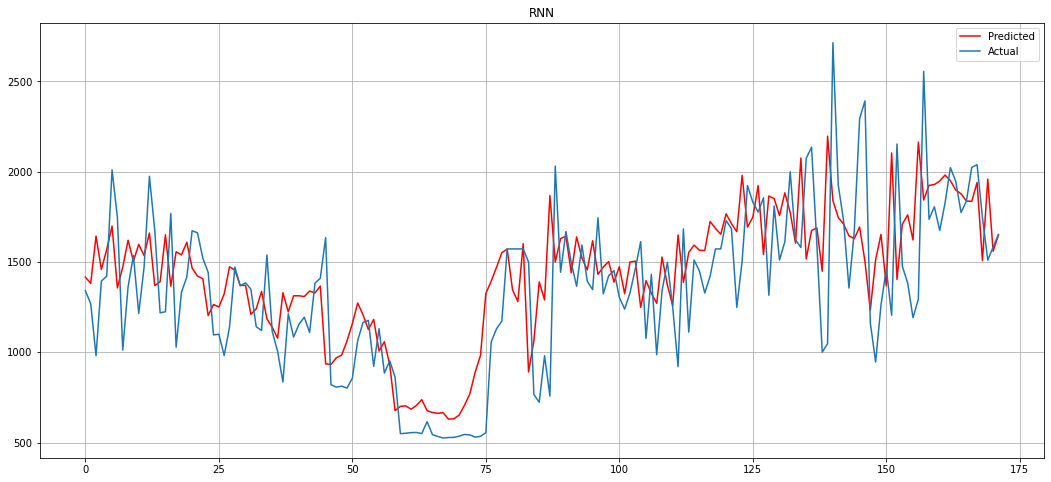

In [17]:
plt.figure(figsize=(18,8))
plt.plot(rnn_preds, "r-", label="Predicted")
plt.plot(y_test_actual, label="Actual")
plt.title('RNN')
plt.legend()
plt.grid(True)
plt.savefig('1 - RNN.jpg', dpi=200)
plt.show()

## LSTM

In [18]:
lstm_preds = scaler_y.inverse_transform(LSTM_preds)
y_test_actual = scaler_y.inverse_transform(pd.DataFrame(y_test))
resultsDict['LSTM'] = evaluate(y_test_actual, lstm_preds)
evaluate(y_test_actual, lstm_preds)

{'mae': 241.31483432677217,
 'rmse': 328.3172058255842,
 'mape': 0.20009993682099722,
 'r2': 0.4441510184209797}

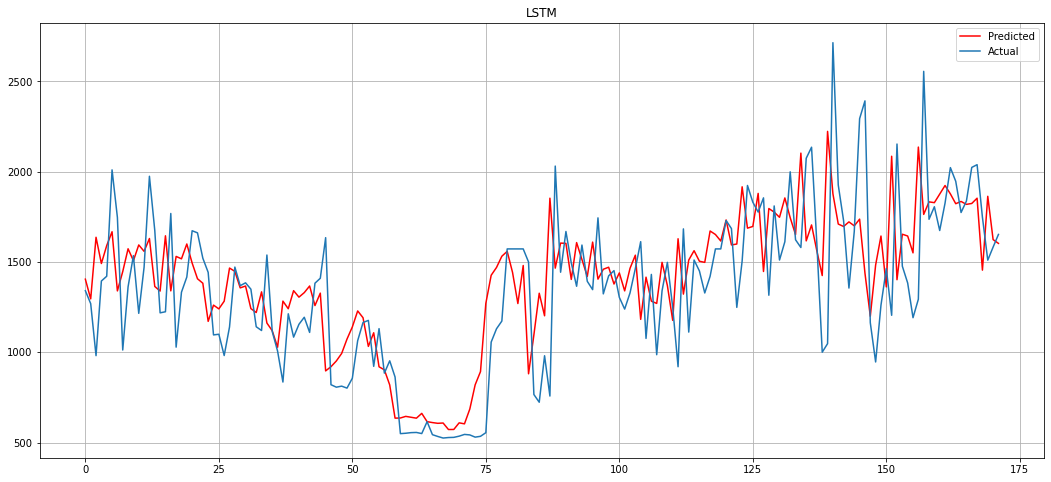

In [19]:
plt.figure(figsize=(18,8))
plt.plot(lstm_preds, "r-", label="Predicted")
plt.plot(y_test_actual, label="Actual")
plt.title('LSTM')
plt.legend()
plt.grid(True)
plt.savefig('2 - LSTM.jpg', dpi=200)
plt.show()

## GRU

In [20]:
gru_preds = scaler_y.inverse_transform(GRU_preds)
y_test_actual = scaler_y.inverse_transform(pd.DataFrame(y_test))
resultsDict['GRU'] = evaluate(y_test_actual, gru_preds)
evaluate(y_test_actual, gru_preds)

{'mae': 241.52843538822015,
 'rmse': 328.8343636351235,
 'mape': 0.20187609451460925,
 'r2': 0.4423985178625587}

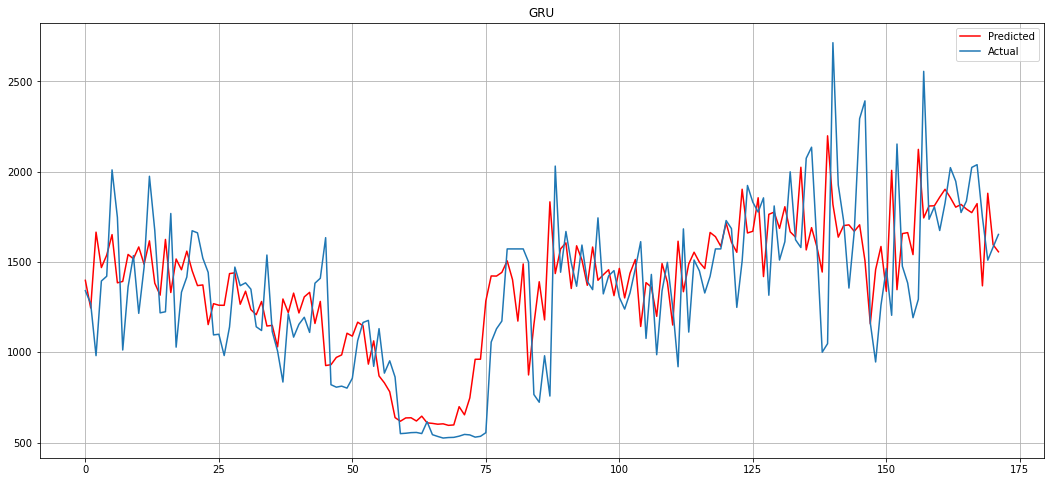

In [21]:
plt.figure(figsize=(18,8))
plt.plot(gru_preds, "r-", label="Predicted")
plt.plot(y_test_actual, label="Actual")
plt.title('GRU')
plt.legend()
plt.grid(True)
plt.savefig('3 - GRU.jpg', dpi=200)
plt.show()

### Rolling RNNs
Train on initial train set, predict next month. Expand training window to include the predictions from next month.  \
1. Predict one month ahead
2. Create features based on predictions
3. Expand training window to include the predictions

Repeated till all predictions are reached

In [22]:
chosen = df_resample.copy()
chosen = create_lags(chosen)
chosen.dropna(inplace=True)

scaler = MinMaxScaler(feature_range=(0, 1))
scaler_x = scaler.fit(chosen.iloc[:,1:])
scaler_y = scaler.fit(chosen.loc[:,['y']])

x_scaled = scaler_x.transform(chosen.iloc[:,1:])
y_scaled = scaler_y.transform(chosen.loc[:,['y']])

scaled = np.hstack((x_scaled, y_scaled))
scaled = pd.DataFrame(scaled, index=chosen.index, columns=chosen.columns)

train = scaled[:1078]
val = scaled[1078:1256]
test = scaled[1256:]

x_train = train.drop(["y"],axis=1)
y_train = train["y"]
x_val = val.drop(["y"],axis=1)
y_val = val["y"]
x_test = test.drop(["y"],axis=1)
y_test = test["y"]

In [23]:
## Helper Function
i = 0
def train_test_split(df, i=0):
    chosen = create_lags(df)
    chosen.dropna(inplace=True)
    x_scaled = scaler_x.transform(chosen.iloc[:,1:])
    y_scaled = scaler_y.transform(chosen.loc[:,['y']])

    scaled = np.hstack((x_scaled, y_scaled))
    scaled = pd.DataFrame(scaled, index=chosen.index, columns=chosen.columns)

    train = scaled[:1078+i]
    val = scaled[1078+i:1256+i]
    test = scaled[1256+i:]
    
    x_train = train.drop(["y"],axis=1)
    y_train = train["y"]
    x_val = val.drop(["y"],axis=1)
    y_val = val["y"]
    x_test = test.drop(["y"],axis=1)
    y_test = test["y"]

    n_features = len(x_train.columns)
    return x_train, x_val, x_test, y_train, y_val, y_test

x_train, x_val, x_test, y_train, y_val, y_test = train_test_split(df_resample, i)
print(x_test.shape)

(179, 7)


In [24]:
df_resample

,y,Lag_1,Lag_2,Lag_3,Lag_4,Lag_5,Lag_6,Lag_7
ds,,,,,,,,
2006-12-23,4773.386,2341.338,1718.80723,2225.74800,1666.19400,2203.82600,3390.46000,1209.176
2006-12-24,2550.012,4773.386,2341.33800,1718.80723,2225.74800,1666.19400,2203.82600,3390.460
2006-12-25,2743.120,2550.012,4773.38600,2341.33800,1718.80723,2225.74800,1666.19400,2203.826
2006-12-26,3934.110,2743.120,2550.01200,4773.38600,2341.33800,1718.80723,2225.74800,1666.194
2006-12-27,1528.760,3934.110,2743.12000,2550.01200,4773.38600,2341.33800,1718.80723,2225.748
...,...,...,...,...,...,...,...,...
2010-11-22,2041.536,900.910,2197.00600,1570.40000,1652.15200,1582.03200,1509.74800,1747.382
2010-11-23,1577.536,2041.536,900.91000,2197.00600,1570.40000,1652.15200,1582.03200,1509.748
2010-11-24,1796.248,1577.536,2041.53600,900.91000,2197.00600,1570.40000,1652.15200,1582.032


# Rolling Scheme - RNN, LSTM, GRU

In [25]:
TIME_STEPS, N_FEATURES = 7, 7
rnn, lstm, gru = list(), list(), list()

for i in range(0, len(x_test), 30):
    temp = df_resample.copy()
    x_train, x_val, x_test, y_train, y_val, y_test = train_test_split(temp, i)
    
    x_train_np = create_features(x_train, TIME_STEPS, N_FEATURES)
    x_val_np = create_features(x_val, TIME_STEPS, N_FEATURES)
    x_test_np = create_features(x_test, TIME_STEPS, N_FEATURES)
    print(x_train_np.shape, x_val_np.shape, x_test_np.shape)
    y_test = y_test[:x_test_np.shape[0]]
    y_train = y_train[:x_train_np.shape[0]]
    y_val = y_val[:x_val_np.shape[0]]
    print(y_train.shape, y_val.shape, y_test.shape)
    
    if y_test.shape[0] != 0:
        RNN_model = fit_model(SimpleRNN, 64, x_train_np, x_val_np)
        LSTM_model = fit_model(LSTM, 64, x_train_np, x_val_np)
        GRU_model = fit_model(GRU, 64, x_train_np, x_val_np)

        RNN_preds = RNN_model.predict(x_test_np)
        yhat_actual = scaler_y.inverse_transform(RNN_preds)
        rnn.extend(yhat_actual.flatten()[:30])
        LSTM_preds = LSTM_model.predict(x_test_np)
        yhat_actual = scaler_y.inverse_transform(LSTM_preds)
        lstm.extend(yhat_actual.flatten()[:30])
        GRU_preds = GRU_model.predict(x_test_np)
        yhat_actual = scaler_y.inverse_transform(GRU_preds)
        gru.extend(yhat_actual.flatten()[:30])

(1071, 7, 7) (171, 7, 7) (165, 7, 7)
(1071,) (171,) (165,)
(1101, 7, 7) (171, 7, 7) (135, 7, 7)
(1101,) (171,) (135,)
(1131, 7, 7) (171, 7, 7) (105, 7, 7)
(1131,) (171,) (105,)
(1161, 7, 7) (171, 7, 7) (75, 7, 7)
(1161,) (171,) (75,)
(1191, 7, 7) (171, 7, 7) (45, 7, 7)
(1191,) (171,) (45,)
(1221, 7, 7) (171, 7, 7) (15, 7, 7)
(1221,) (171,) (15,)


In [28]:
resultsDict['RNN Rolling'] = evaluate(y_test_actual[7:], rnn)
evaluate(y_test_actual[7:], rnn)

{'mae': 453.4139439066641,
 'rmse': 569.9576616682361,
 'mape': 0.4237547526601375,
 'r2': 0.4420011906344219}

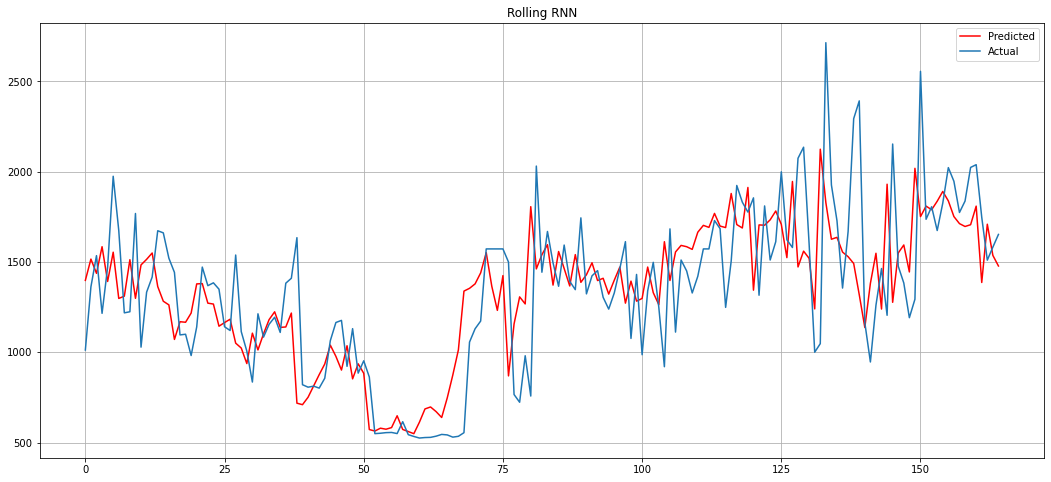

In [29]:
plt.figure(figsize=(18,8))
plt.plot(rnn, "r-", label="Predicted")
plt.plot(y_test_actual[7:], label="Actual")
plt.legend()
plt.title('Rolling RNN')
plt.grid(True)
plt.savefig('4 - RNN (Rolling).jpg', dpi=200)
plt.show()

In [30]:
resultsDict['LSTM Rolling'] = evaluate(y_test_actual[7:], lstm)
evaluate(y_test_actual[7:], lstm)

{'mae': 449.92188021791435,
 'rmse': 567.1221245855187,
 'mape': 0.43291466133081563,
 'r2': 0.4592669488110137}

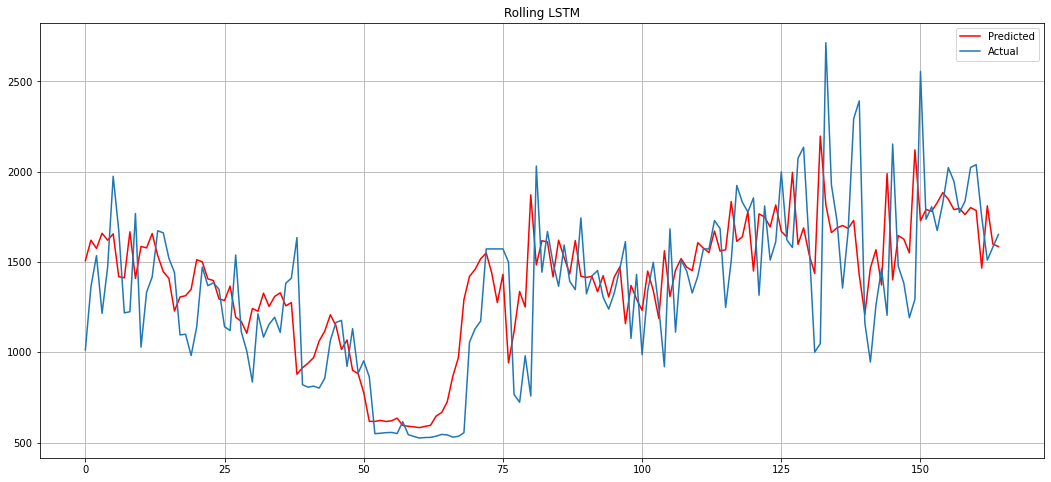

In [31]:
plt.figure(figsize=(18,8))
plt.plot(lstm, "r-", label="Predicted")
plt.plot(y_test_actual[7:], label="Actual")
plt.legend()
plt.title('Rolling LSTM')
plt.grid(True)
plt.savefig('5 - LSTM (Rolling).jpg', dpi=200)
plt.show()

In [32]:
resultsDict['GRU Rolling'] = evaluate(y_test_actual[7:], gru)
evaluate(y_test_actual[7:], gru)

{'mae': 450.9237689803466,
 'rmse': 567.2770811085909,
 'mape': 0.4316553680653346,
 'r2': 0.46093011457452626}

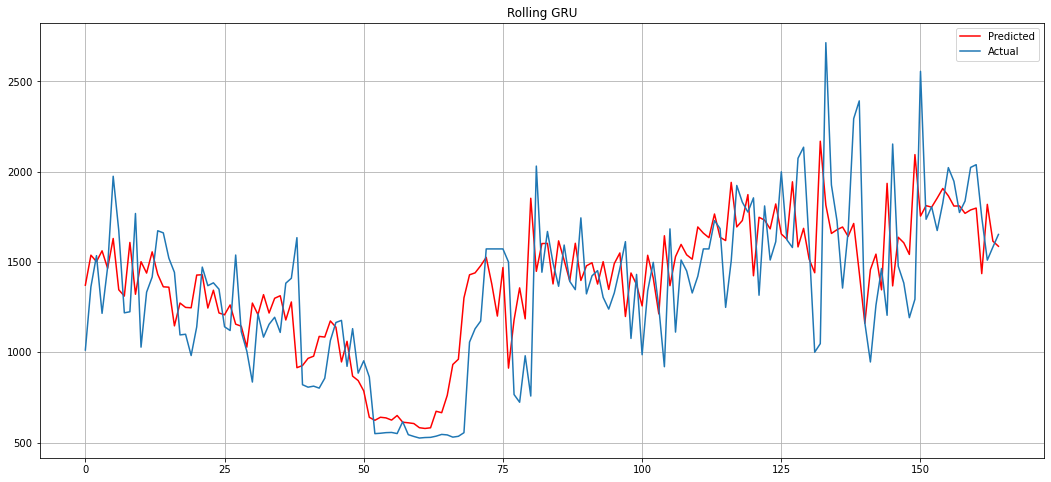

In [33]:
plt.figure(figsize=(18,8))
plt.plot(gru, "r-", label="Predicted")
plt.plot(y_test_actual[7:], label="Actual")
plt.legend()
plt.title('Rolling GRU')
plt.grid(True)
plt.savefig('6 - GRU (Rolling).jpg', dpi=200)
plt.show()

# Results

In [34]:
resultsDict

{'RNN': {'mae': 251.85238979188978,
  'rmse': 336.0320107394248,
  'mape': 0.21649271437818815,
  'r2': 0.4177213993384381},
 'LSTM': {'mae': 241.31483432677217,
  'rmse': 328.3172058255842,
  'mape': 0.20009993682099722,
  'r2': 0.4441510184209797},
 'GRU': {'mae': 241.52843538822015,
  'rmse': 328.8343636351235,
  'mape': 0.20187609451460925,
  'r2': 0.4423985178625587},
 'RNN Rolling': {'mae': 453.4139439066641,
  'rmse': 569.9576616682361,
  'mape': 0.4237547526601375,
  'r2': 0.4420011906344219},
 'LSTM Rolling': {'mae': 449.92188021791435,
  'rmse': 567.1221245855187,
  'mape': 0.43291466133081563,
  'r2': 0.4592669488110137},
 'GRU Rolling': {'mae': 450.9237689803466,
  'rmse': 567.2770811085909,
  'mape': 0.4316553680653346,
  'r2': 0.46093011457452626}}

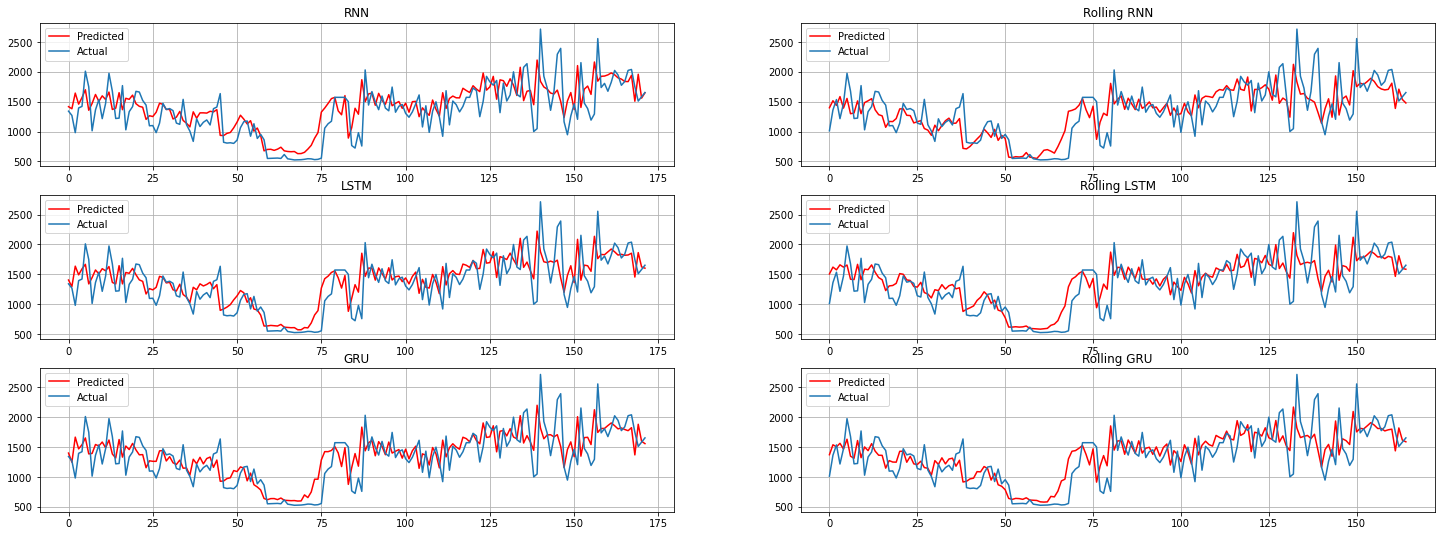

In [35]:
fig,a =  plt.subplots(3,2, figsize=(25,9))

a[0][0].plot(rnn_preds, "r-", label="Predicted")
a[0][0].plot(y_test_actual, label="Actual")
a[0][0].legend()
a[0][0].grid(True)
a[0][0].set_title('RNN')
a[0][1].plot(rnn, "r-", label="Predicted")
a[0][1].plot(y_test_actual[7:], label="Actual")
a[0][1].legend()
a[0][1].grid(True)
a[0][1].set_title('Rolling RNN')
a[1][0].plot(lstm_preds, "r-", label="Predicted")
a[1][0].plot(y_test_actual, label="Actual")
a[1][0].legend()
a[1][0].grid(True)
a[1][0].set_title('LSTM')
a[1][1].plot(lstm, "r-", label="Predicted")
a[1][1].plot(y_test_actual[7:], label="Actual")
a[1][1].legend()
a[1][1].grid(True)
a[1][1].set_title('Rolling LSTM')
a[2][0].plot(gru_preds, "r-", label="Predicted")
a[2][0].plot(y_test_actual, label="Actual")
a[2][0].legend()
a[2][0].grid(True)
a[2][0].set_title('GRU')
a[2][1].plot(gru, "r-", label="Predicted")
a[2][1].plot(y_test_actual[7:], label="Actual")
a[2][1].legend()
a[2][1].grid(True)
a[2][1].set_title('Rolling GRU')
plt.savefig('Summary.jpg', dpi=200)
plt.show()